# Rainband Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the rainband of a tropical cyclone. We define rainband lightning as lightning occuring between 200-400km of the storm center. For rainband lightning, we also categorize lightning events by shear quadrants (calculated in [data_pipeline/rainband_data.ipynb](../data_pipeline/rainband_data.ipynb)). Shear quadrants are defined following this graphic below:

<img src="../shear_quadrant_graphic.png" width="200" height="200">

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.

We start by evaluating each tropical cyclone (TC) individually and looking at the bursts over the different shear quadrants. Below are the different basins:
* ATL - Atlantic Ocean basin
* CPAC - Central Pacific basin
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

We only consider lightning data associated with wind speeds greater than 40 knots and time bins with lightning counts greater than 0 in our calculation of lightning burst thresholds. We log transform the lightning counts and use the following 6 threshold methods (referred to by the names in parentheses hereafter):
- [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) - 4 MAD (**MAD1**)
    - This method sets the threshold to be 4 times the median absolute deviation above the median log-lightning count
    - Equation: threshold = median + 4 * MAD
- Median Absolute Deviation - 5 MAD (**MAD2**)
    - This method sets the threshold to be 5 times the median absolute deviation above the median log-lightning count
    - Equation: threshold = median + 5 * MAD
- [Interquartile Range](https://en.wikipedia.org/wiki/Interquartile_range) - 1 IQR (**IQR1**)
    - This method sets the threshold to be 1 interquartile range higher than the upper quartile (Q3) log-lightning count
    - Equation: threshold = Q3 + 1 * IQR
- Interquartile Range - 1.5 IQR (**IQR2**)
    - This method sets the threshold to be 1.5 interquartile ranges higher than the upper quartile (Q3) log-lightning count
    - Equation: threshold = Q3 + 1.5 * IQR
- [Lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution) - 2 Standard Deviations (**LOGN1**)
    - This method sets the threshold to be 2 standard deviations higher than the mean log-lightning count
    - Equation: threshold = mean + 2 * std dev
- Lognormal - 3 Standard Deviations (**LOGN2**)
    - This method sets the threshold to be 3 standard deviations higher than the mean log-lightning count
    - Equation: threshold = mean + 3 * std dev

**note that all methods use the log-lightning count as base (e.g. median refers to median log-lightning count, not median lightning count)


## Code
### Import Libraries and Files
Let's start by importing necessary libraries and files. The rainband dataset is created in the `rainband_data.ipynb` notebook as `rainband_shear_timebin_joined.csv`. This file can be found in the `data_pipeline/data/` directory of the repository.

In [1]:
import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches
from lightning_threshold_functions import *

In [2]:
rainband_data = pd.read_csv("../data_pipeline/data/rainband_shear_timebin_joined.csv")
rainband_data = pl.from_pandas(rainband_data)

In [3]:
rainband_data.head()

shape: (5, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ 24_hour_k ┆ 24_hour_p ┆ TC_Catego ┆ Intensif │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ nots_diff ┆ ressure_d ┆ ry        ┆ ication_ │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ iff       ┆ ---       ┆ Category │
│           ┆ str       ┆ str       ┆ i64       ┆   ┆ f64       ┆ ---       ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [4]:
# import data from csv file
rainband_data = rainband_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"), # Parse basin from storm code
    pl.col("lightning_count").log1p().alias("log_lightning_count"), # Log transform the counts
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
rainband_data = rainband_data.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
rainband_data = rainband_data.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
rainband_data.head()

shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ 24_hour_p ┆ Current_C ┆ Intensifi ┆ log_ligh │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ ressure_d ┆ ategory   ┆ cation_Ca ┆ tning_co │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ iff       ┆ ---       ┆ tegory_5  ┆ unt      │
│ μs]       ┆ str       ┆ str       ┆ i64       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ str       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

We map the intensification bins into 3, combining the rapidly weakening and weakening bins, and the rapidly intensifying and intensifying bins.

In [5]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
rainband_data = rainband_data.with_columns(
    rainband_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

rainband_data.head()

shape: (5, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ Current_C ┆ Intensifi ┆ log_light ┆ Intensif │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ ategory   ┆ cation_Ca ┆ ning_coun ┆ ication_ │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ tegory_5  ┆ t         ┆ Category │
│ μs]       ┆ str       ┆ str       ┆ i64       ┆   ┆ str       ┆ ---       ┆ ---       ┆ _3       │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [6]:
# Create dataframe for filtering later
storm_names = rainband_data[["storm_code", "storm_name"]].unique()

-------------------------

### Individual TC Analysis
We start by applying the 6 different thresholds to each TC individually, where we evaluate burst thresholds in comparison to a TC's own lightning activity for time bins associated with wind speeds greater than or equal to 40 knots. We do not group by shear quadrant when evaluating burst thresholds, but we will look at the shear quadrant associated with identified bursts. 

We start by filtering out data associated with wind speeds less than 40 knots.

In [7]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = rainband_data.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

We then apply the functions to the data, including timebins with no lightning activity (0 lightning count).

In [8]:
# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds(pd_data)

tc_summary_w_0 = create_tc_summary(bursts_w_0, rainband=True)
tc_summary_w_0.head(10)

storm_code shear_quad  mad1_bursts  mad2_bursts  mad1_threshold  \
0   ATL_10_1         DL          121          121             0.0   
1   ATL_10_1         DR           92           92             0.0   
2   ATL_10_1         UL           99           99             0.0   
3   ATL_10_1         UR           77           77             0.0   
4  ATL_10_11         DL          144          144             0.0   
5  ATL_10_11         DR          289          289             0.0   
6  ATL_10_11         UL           96           96             0.0   
7  ATL_10_11         UR          250          250             0.0   
8  ATL_10_12         DL           73           73             0.0   
9  ATL_10_12         DR          127          127             0.0   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0             0.0           22            0        4.969813        6.212267   
1             0.0            4            0        4.969813        6.212267   
2             0.0            2            0        4.969813        6.212267   
3             0.0            5            0        4.969813        6.212267   
4             0.0           40           23        2.197225        2.746531   
5             0.0          176          139        2.197225        2.746531   
6             0.0           27           12        2.197225        2.746531   
7             0.0          119           68        2.197225        2.746531   
8             0.0           73           73        0.000000        0.000000   
9             0.0          127          127        0.000000        0.000000   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             0         4.559965         6.217398         211      57.35   
1  ...             0         4.559965         6.217398         211      43.60   
2  ...             0         4.559965         6.217398         211      46.92   
3  ...             0         4.559965         6.217398         211      36.49   
4  ...             0         3.203989         4.435583         565      25.49   
5  ...            23         3.203989         4.435583         565      51.15   
6  ...             0         3.203989         4.435583         565      16.99   
7  ...             4         3.203989         4.435583         565      44.25   
8  ...             8         1.401047         1.997657         390      18.72   
9  ...            35         1.401047         1.997657         390      32.56   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      57.35      10.43       0.00       13.27        0.00  
1      43.60       1.90       0.00        2.37        0.00  
2      46.92       0.95       0.00        1.90        0.00  
3      36.49       2.37       0.00        2.37        0.00  
4      25.49       7.08       4.07        2.12        0.00  
5      51.15      31.15      24.60       18.23        4.07  
6      16.99       4.78       2.12        0.35        0.00  
7      44.25      21.06      12.04        8.14        0.71  
8      18.72      18.72      18.72        5.38        2.05  
9      32.56      32.56      32.56       13.85        8.97  

[10 rows x 21 columns]

In [9]:
# Get mean threshold value for each of the 6 options
tc_summary_w_0_mean = tc_summary_w_0.drop(columns=(["storm_code", "shear_quad"])).mean()
print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
tc_summary_w_0_median = tc_summary_w_0.drop(columns=(["storm_code", "shear_quad"])).median()
print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

mad1_threshold     0.181550
mad2_threshold     0.217860
iqr1_threshold     1.252702
iqr2_threshold     1.565878
logn1_threshold    2.577663
logn2_threshold    3.597975
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     0.000000
iqr2_threshold     0.000000
logn1_threshold    2.446661
logn2_threshold    3.455909
dtype: float64


We can see that the threshold values are all very low, meaning that any lightning activity is likely to be flagged as a burst. We plot one TC below to look at a specific example. This can be expected, as we know that many of the timebins have no lightning activity, therefore skewing the threshold lower.

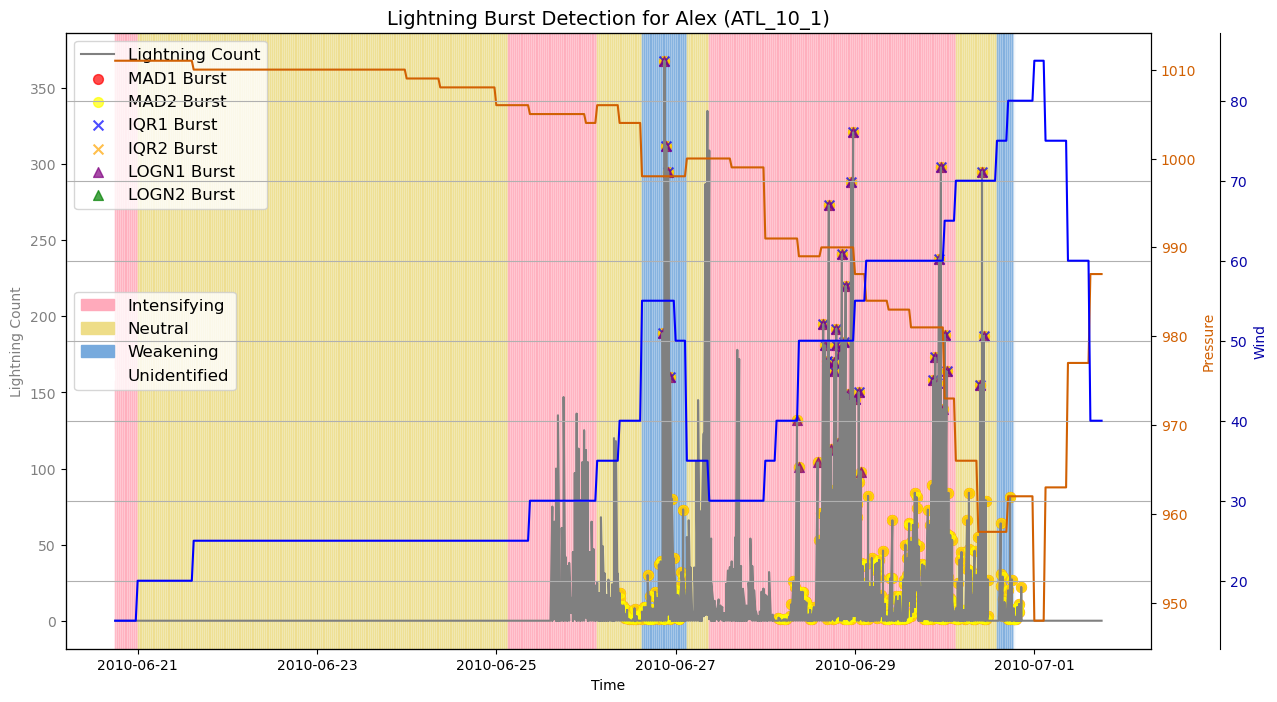

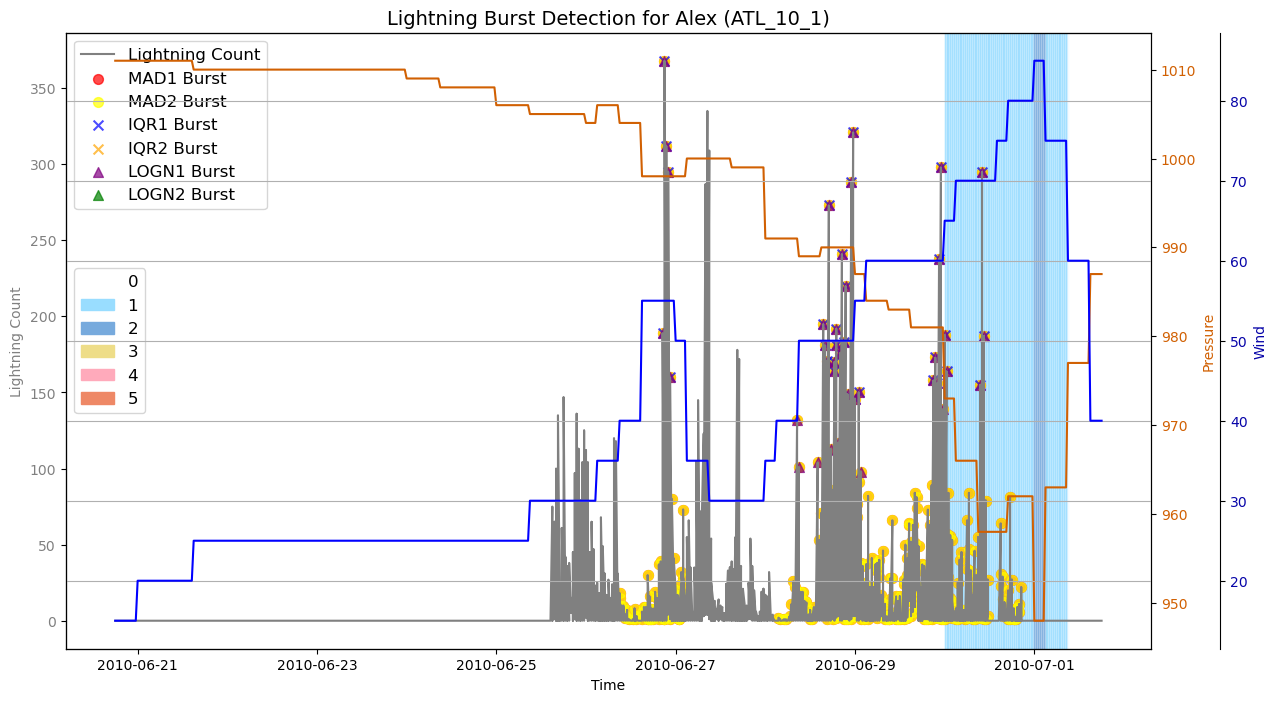

storm_code shear_quad  mad1_bursts  mad2_bursts  mad1_threshold  \
0   ATL_10_1         DL          121          121             0.0   
1   ATL_10_1         DR           92           92             0.0   
2   ATL_10_1         UL           99           99             0.0   
3   ATL_10_1         UR           77           77             0.0   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0             0.0           22            0        4.969813        6.212267   
1             0.0            4            0        4.969813        6.212267   
2             0.0            2            0        4.969813        6.212267   
3             0.0            5            0        4.969813        6.212267   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             0         4.559965         6.217398         211      57.35   
1  ...             0         4.559965         6.217398         211      43.60   
2  ...             0         4.559965         6.217398         211      46.92   
3  ...             0         4.559965         6.217398         211      36.49   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      57.35      10.43        0.0       13.27         0.0  
1      43.60       1.90        0.0        2.37         0.0  
2      46.92       0.95        0.0        1.90         0.0  
3      36.49       2.37        0.0        2.37         0.0  

[4 rows x 21 columns]

In [10]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'

plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

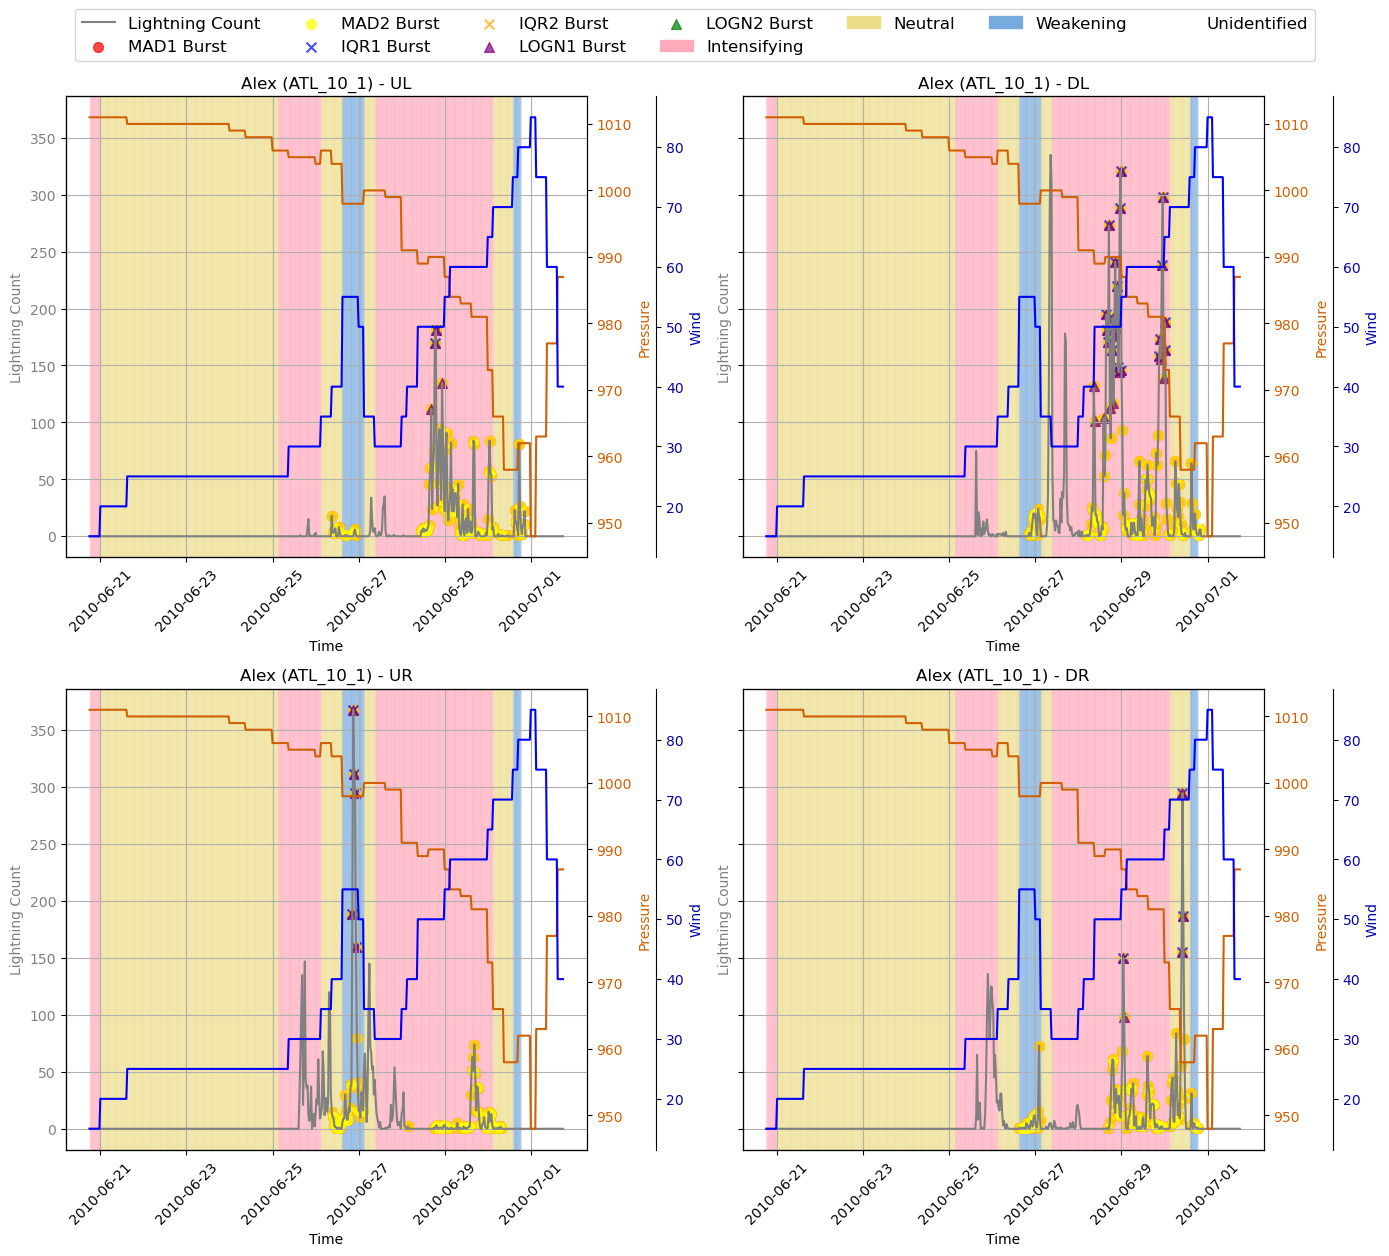

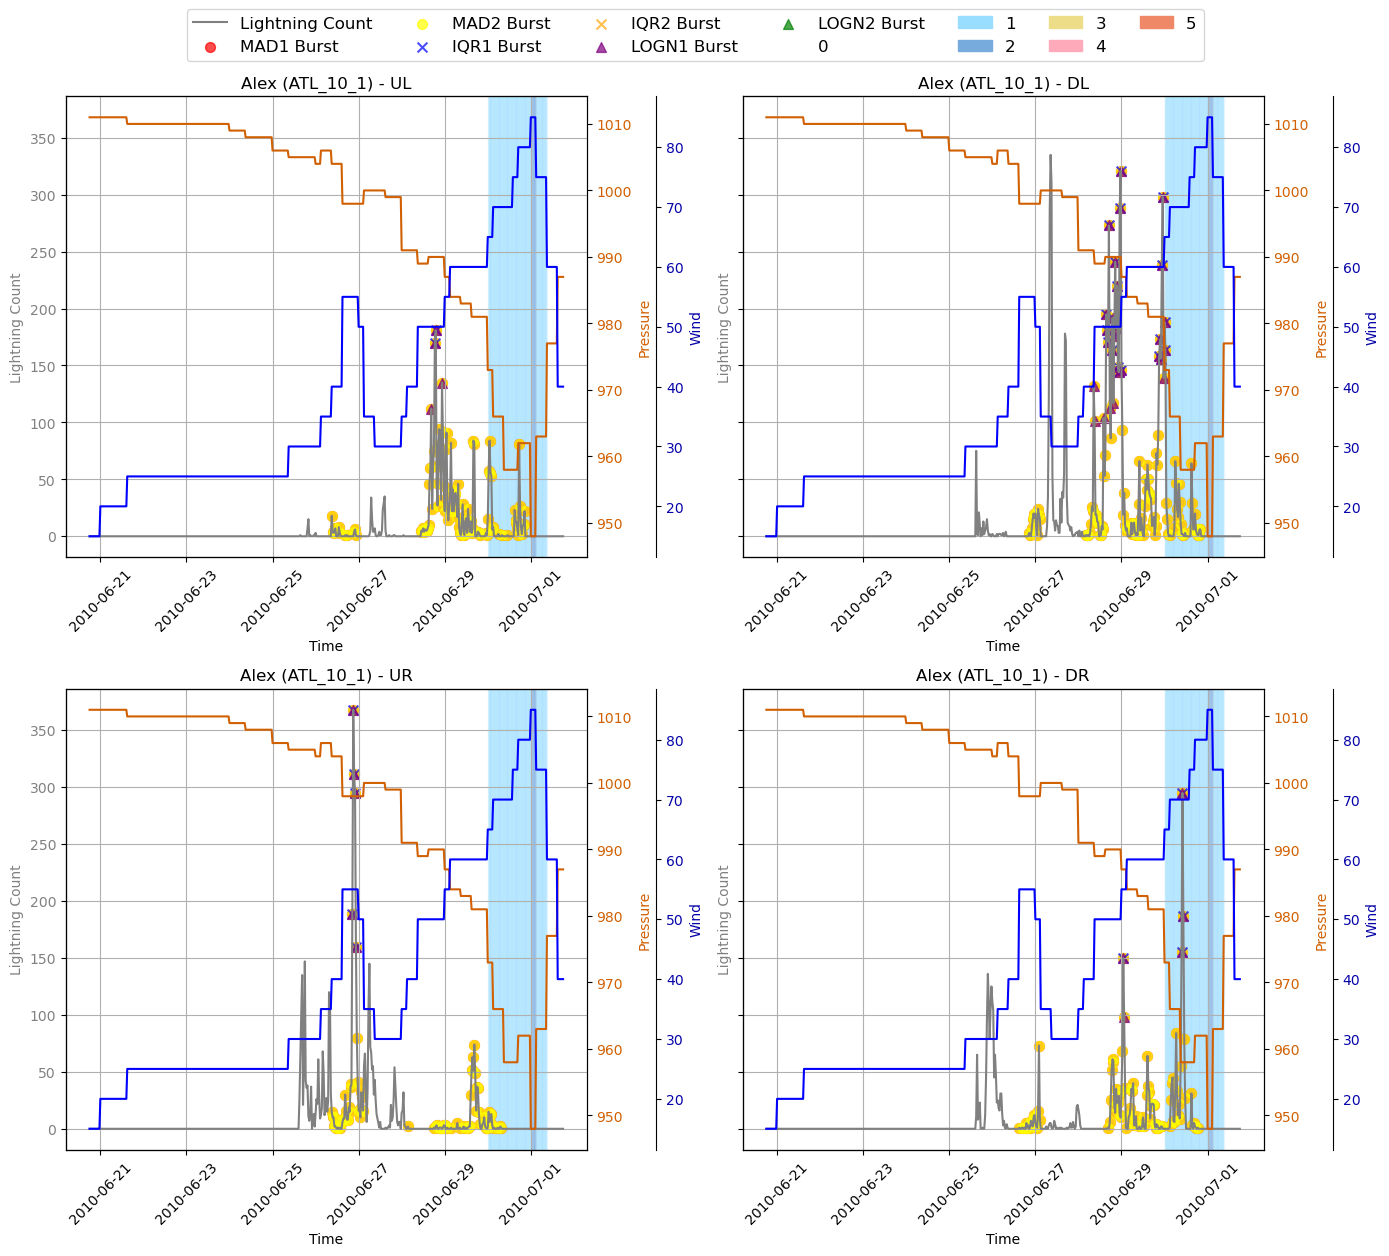

In [11]:
# ATL_10_1 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts_w_0, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts_w_0, storm_names, rainband_data, "c5")

We then apply the threshold evaluation to the dataset without timebins with 0 lightning count. This slightly alters our definition of a lightning burst - we compare each set of lightning events to other nonzero lightning events. This should bring up the threshold and bring down the percent of timebins flagged as a burst.

In [12]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds(pd_data_drop0)

tc_summary = create_tc_summary(bursts, rainband=True)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

storm_code storm_name shear_quad  mad1_bursts  mad2_bursts  mad1_threshold  \
0  WPAC_17_24     Khanun         DL            4            1        3.960585   
1  WPAC_17_24     Khanun         DR            0            0        3.960585   
2  WPAC_17_24     Khanun         UL            0            0        3.960585   
3  WPAC_17_24     Khanun         UR            0            0        3.960585   
4  WPAC_15_24      Koppu         DL            0            0        5.111313   
5  WPAC_15_24      Koppu         DR            0            0        5.111313   
6  WPAC_15_24      Koppu         UL            0            0        5.111313   
7  WPAC_15_24      Koppu         UR            0            0        5.111313   
8   EPAC_16_8  Georgette         DL            1            0        1.706810   
9   EPAC_16_8  Georgette         DR            0            0        1.706810   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  ...  \
0        4.548371            9            3        3.453878  ...   
1        4.548371            0            0        3.453878  ...   
2        4.548371            0            0        3.453878  ...   
3        4.548371            0            0        3.453878  ...   
4        5.986782            0            0        4.031286  ...   
5        5.986782            1            0        4.031286  ...   
6        5.986782            0            0        4.031286  ...   
7        5.986782            6            1        4.031286  ...   
8        1.909543            0            0        2.799211  ...   
9        1.909543            0            0        2.799211  ...   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             1         3.675962         4.630970          55       7.27   
1             0         3.675962         4.630970          27       0.00   
2             0         3.675962         4.630970          29       0.00   
3             0         3.675962         4.630970          27       0.00   
4             0         3.807272         4.800665          95       0.00   
5             0         3.807272         4.800665          84       0.00   
6             0         3.807272         4.800665          60       0.00   
7             1         3.807272         4.800665          92       0.00   
8             0         3.062043         3.937182           6      16.67   
9             0         3.062043         3.937182           2       0.00   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0       1.82      16.36       5.45       12.73        1.82  
1       0.00       0.00       0.00        0.00        0.00  
2       0.00       0.00       0.00        0.00        0.00  
3       0.00       0.00       0.00        0.00        0.00  
4       0.00       0.00       0.00        0.00        0.00  
5       0.00       1.19       0.00        2.38        0.00  
6       0.00       0.00       0.00        0.00        0.00  
7       0.00       6.52       1.09       10.87        1.09  
8       0.00       0.00       0.00        0.00        0.00  
9       0.00       0.00       0.00        0.00        0.00  

[10 rows x 22 columns]

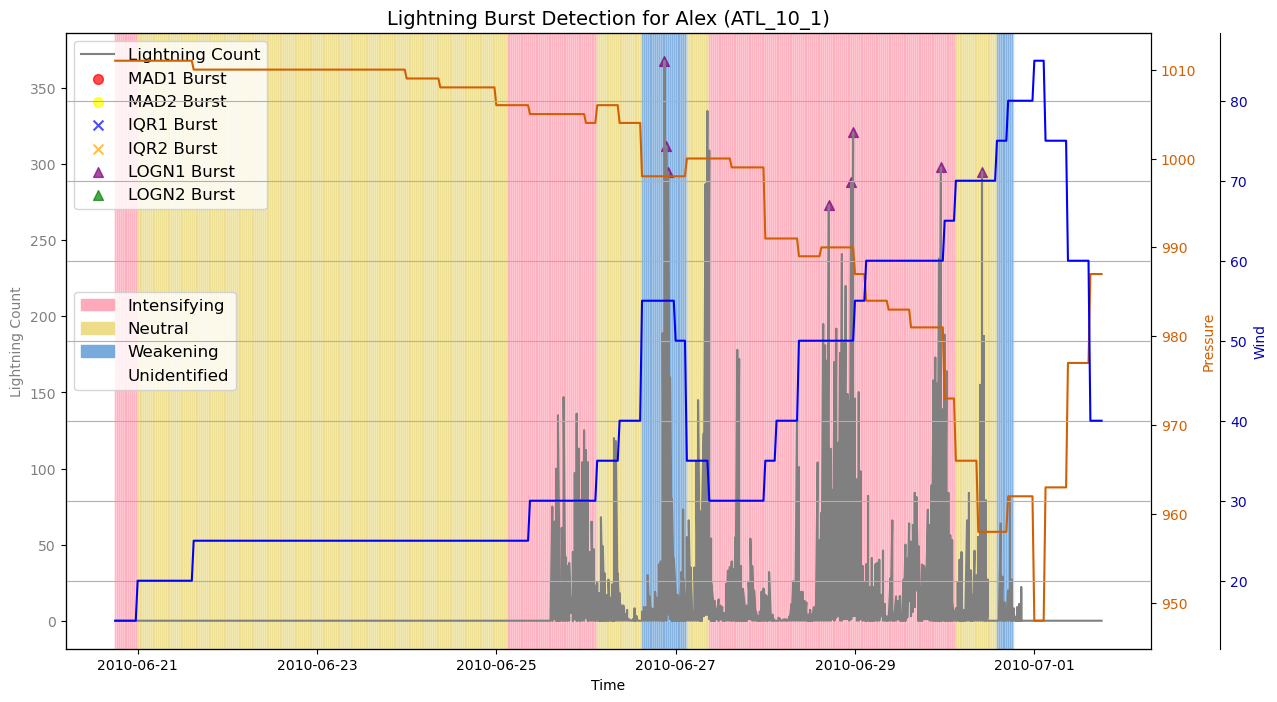

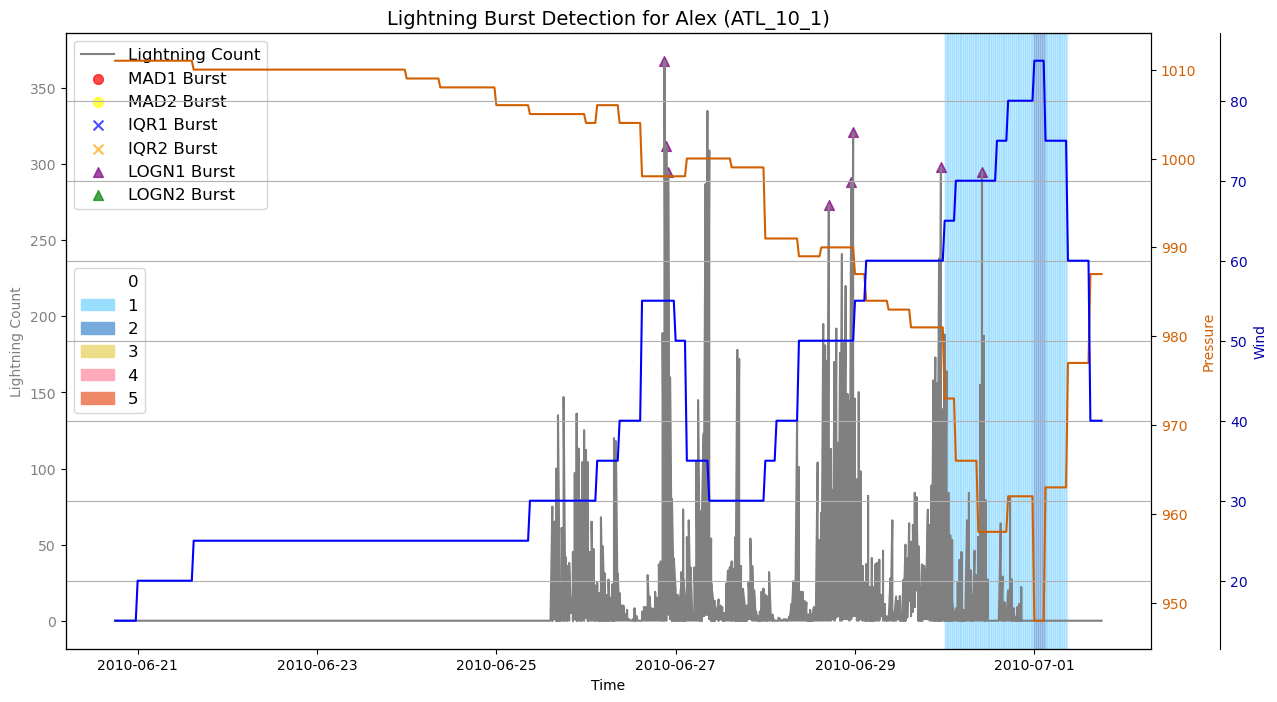

storm_code storm_name shear_quad  mad1_bursts  mad2_bursts  \
1099   ATL_10_1       Alex         DL            0            0   
1100   ATL_10_1       Alex         DR            0            0   
1101   ATL_10_1       Alex         UL            0            0   
1102   ATL_10_1       Alex         UR            0            0   

      mad1_threshold  mad2_threshold  iqr1_bursts  iqr2_bursts  \
1099        7.397394        8.586978            0            0   
1100        7.397394        8.586978            0            0   
1101        7.397394        8.586978            0            0   
1102        7.397394        8.586978            0            0   

      iqr1_threshold  ...  logn2_bursts  logn1_threshold  logn2_threshold  \
1099         6.04085  ...             0          5.54689         6.969608   
1100         6.04085  ...             0          5.54689         6.969608   
1101         6.04085  ...             0          5.54689         6.969608   
1102         6.04085  ...             0          5.54689         6.969608   

      total_bins  mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  \
1099         121        0.0        0.0        0.0        0.0        3.31   
1100          92        0.0        0.0        0.0        0.0        1.09   
1101          99        0.0        0.0        0.0        0.0        0.00   
1102          77        0.0        0.0        0.0        0.0        3.90   

      logn2_prop  
1099         0.0  
1100         0.0  
1101         0.0  
1102         0.0  

[4 rows x 22 columns]

In [13]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

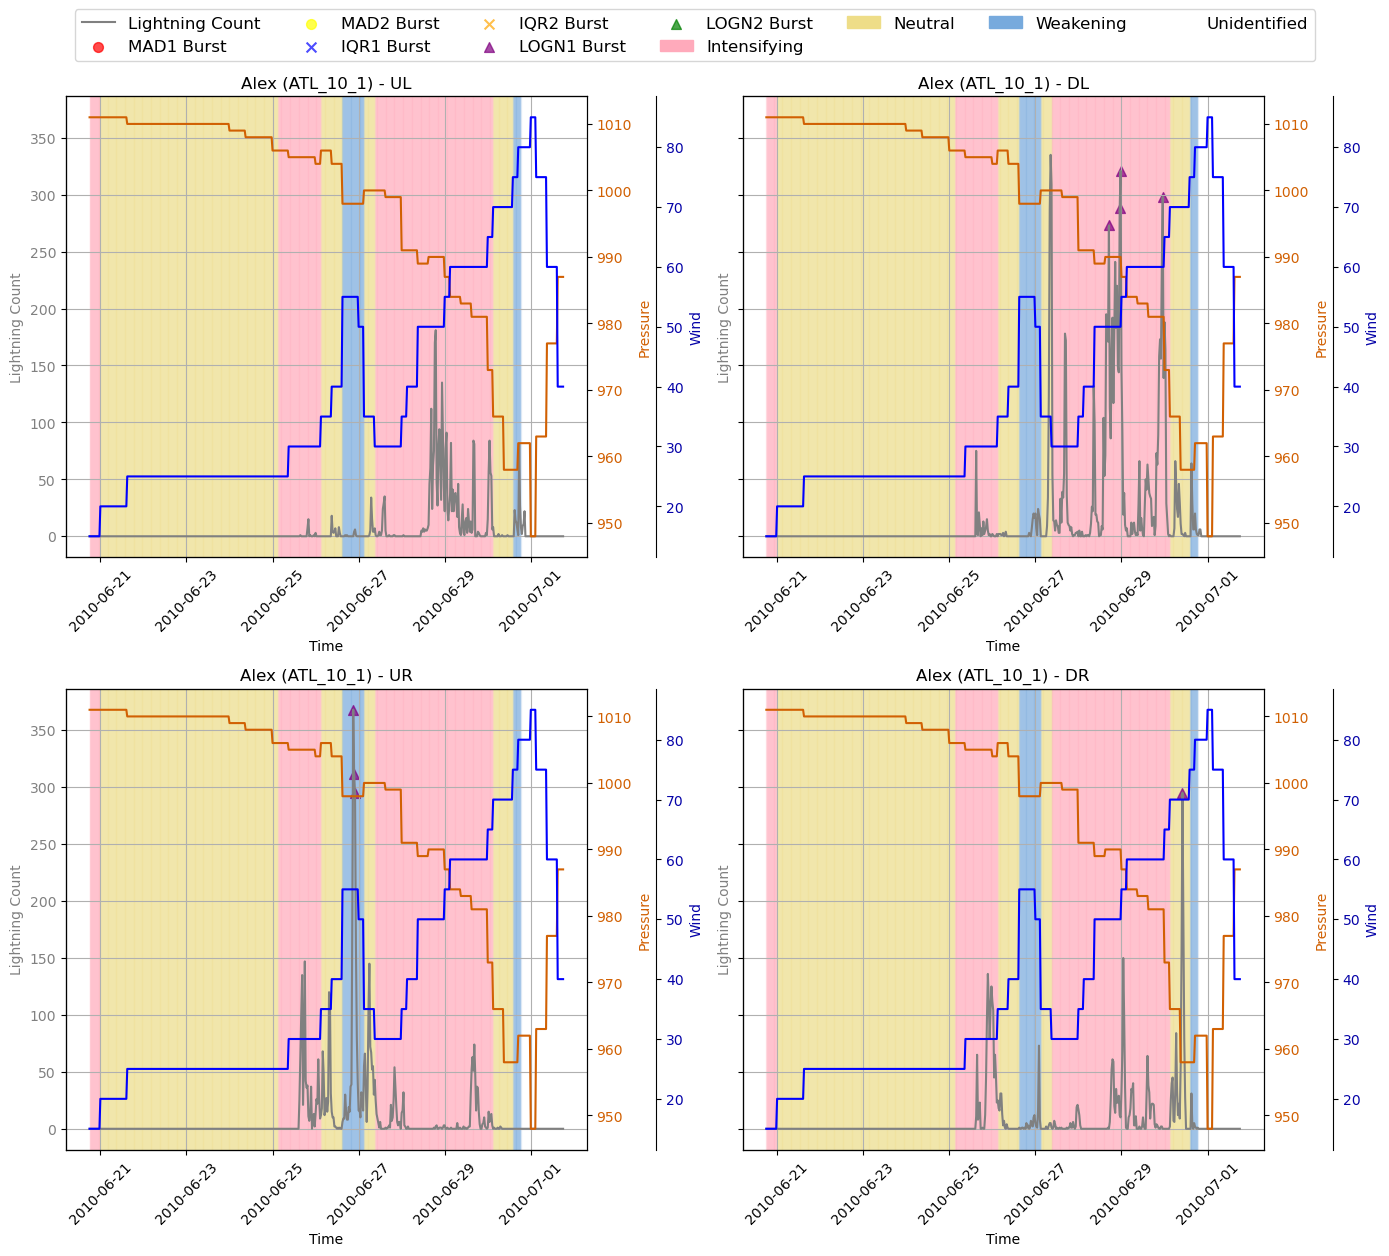

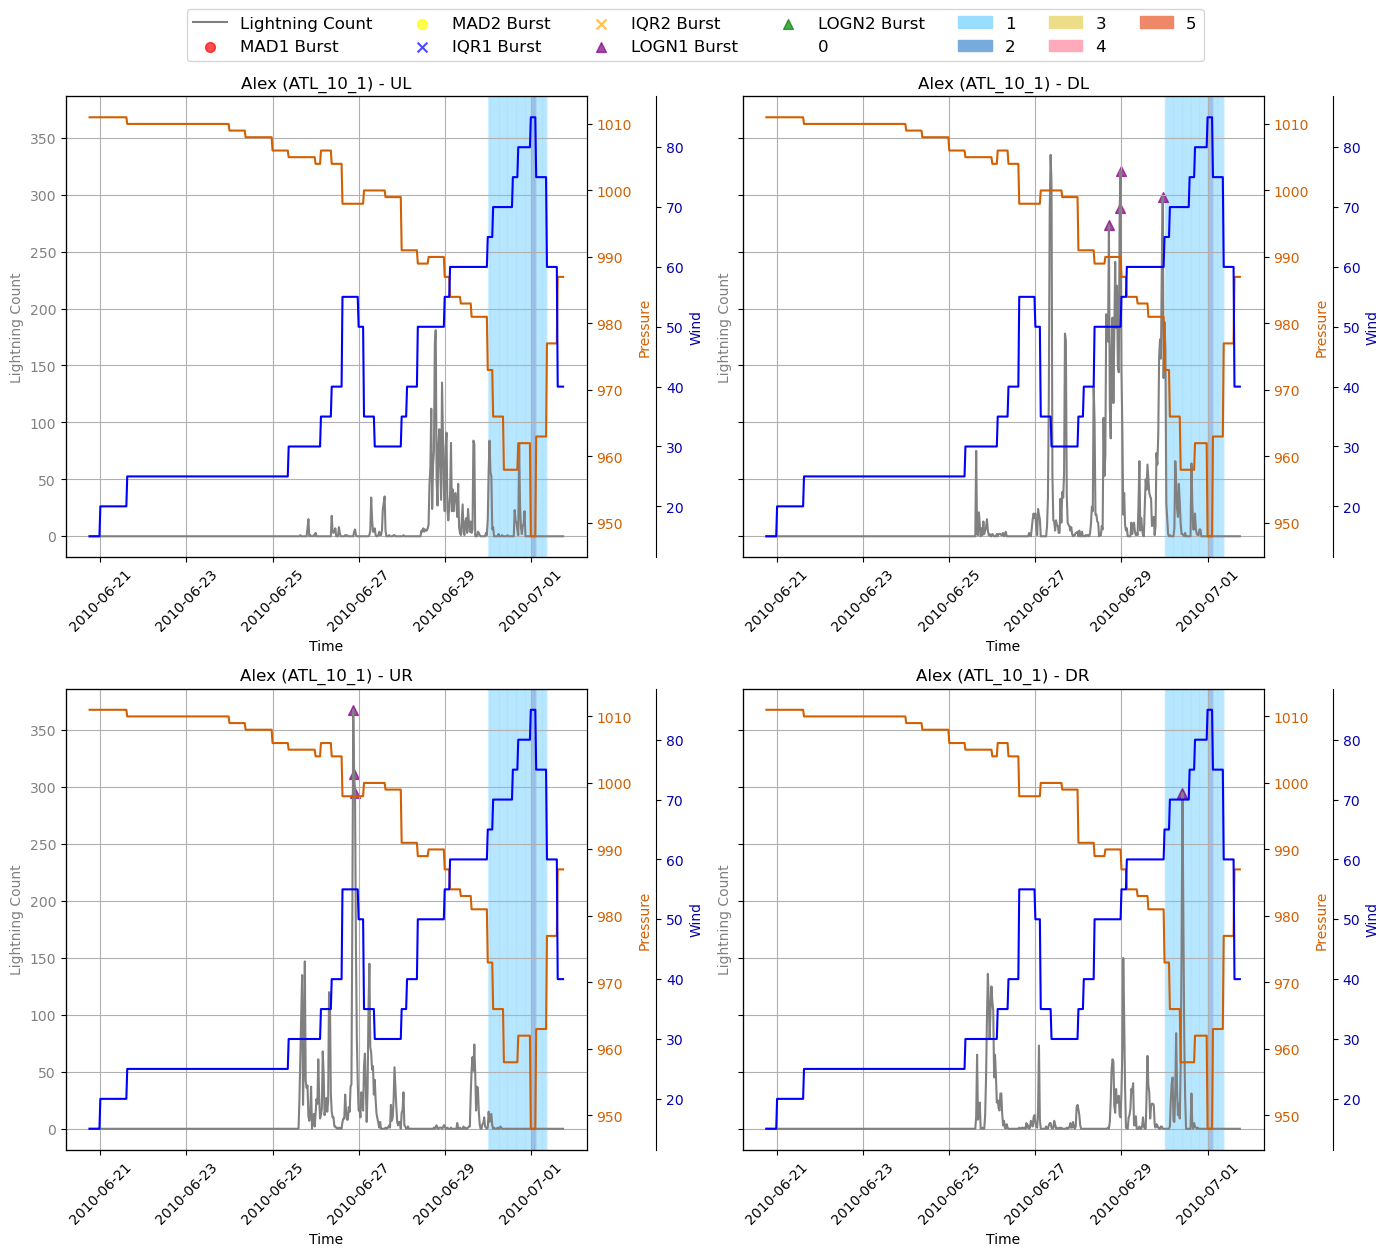

In [14]:
# ATL_10_1 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

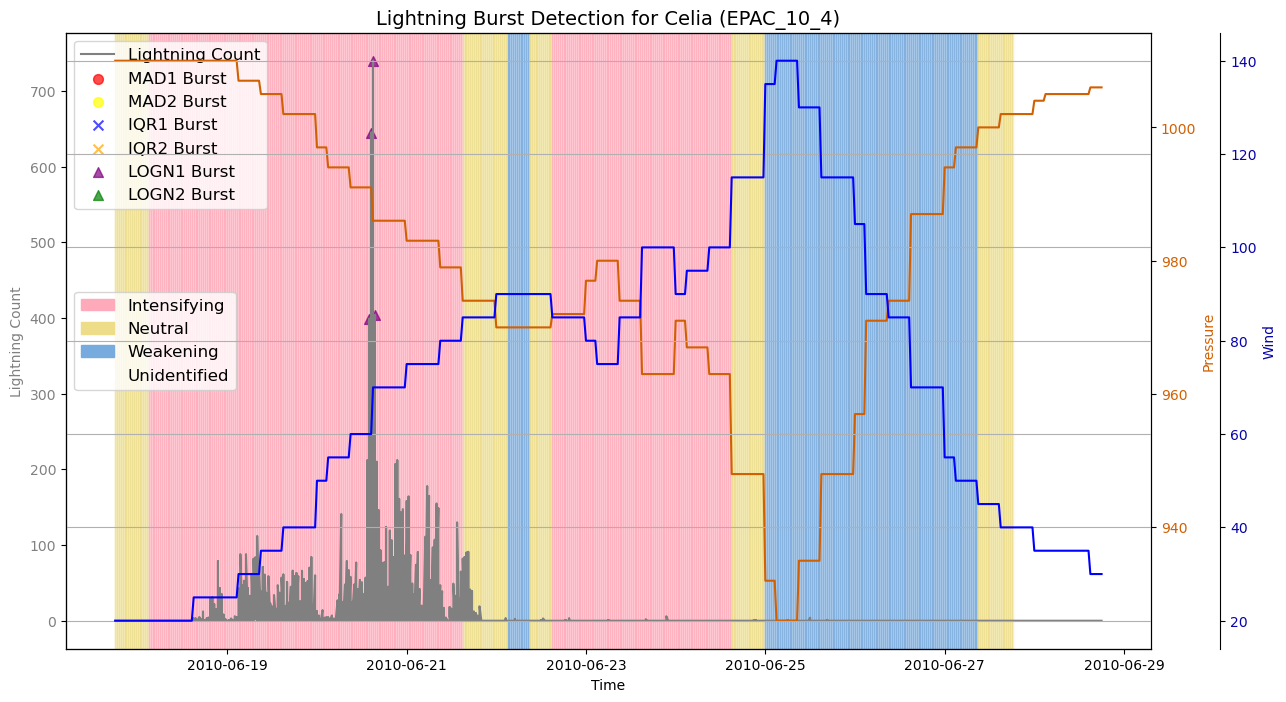

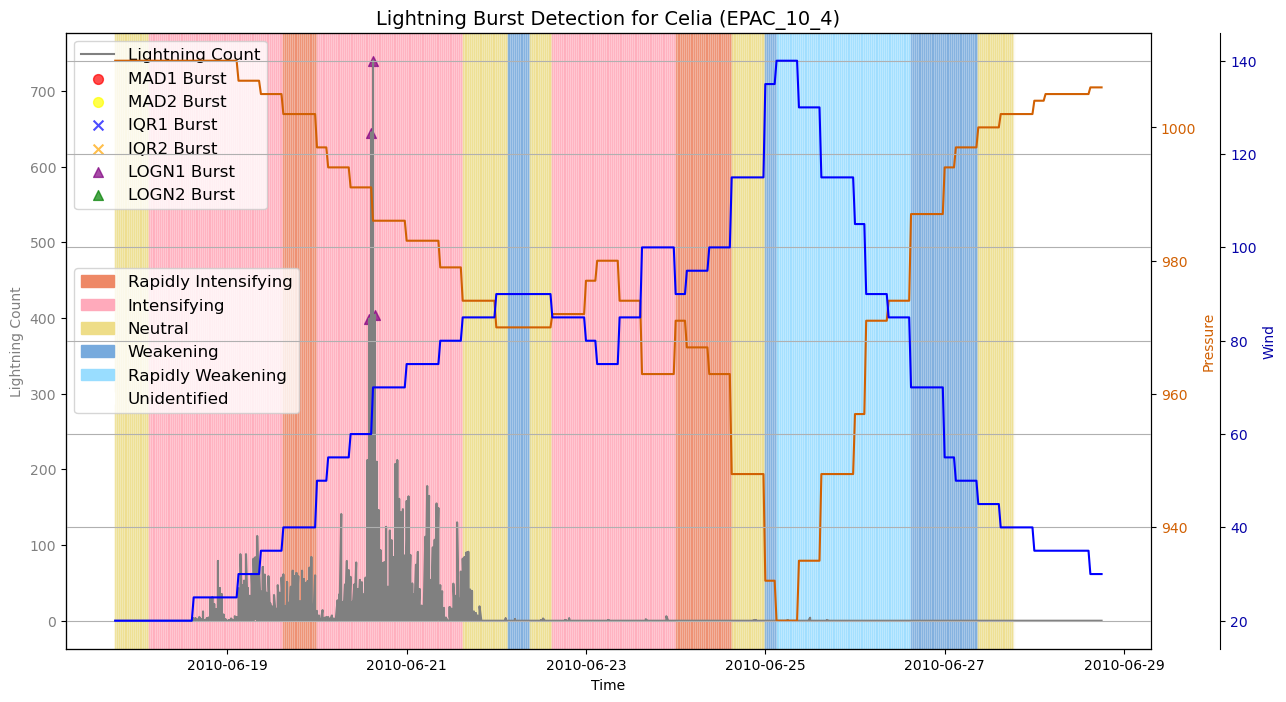

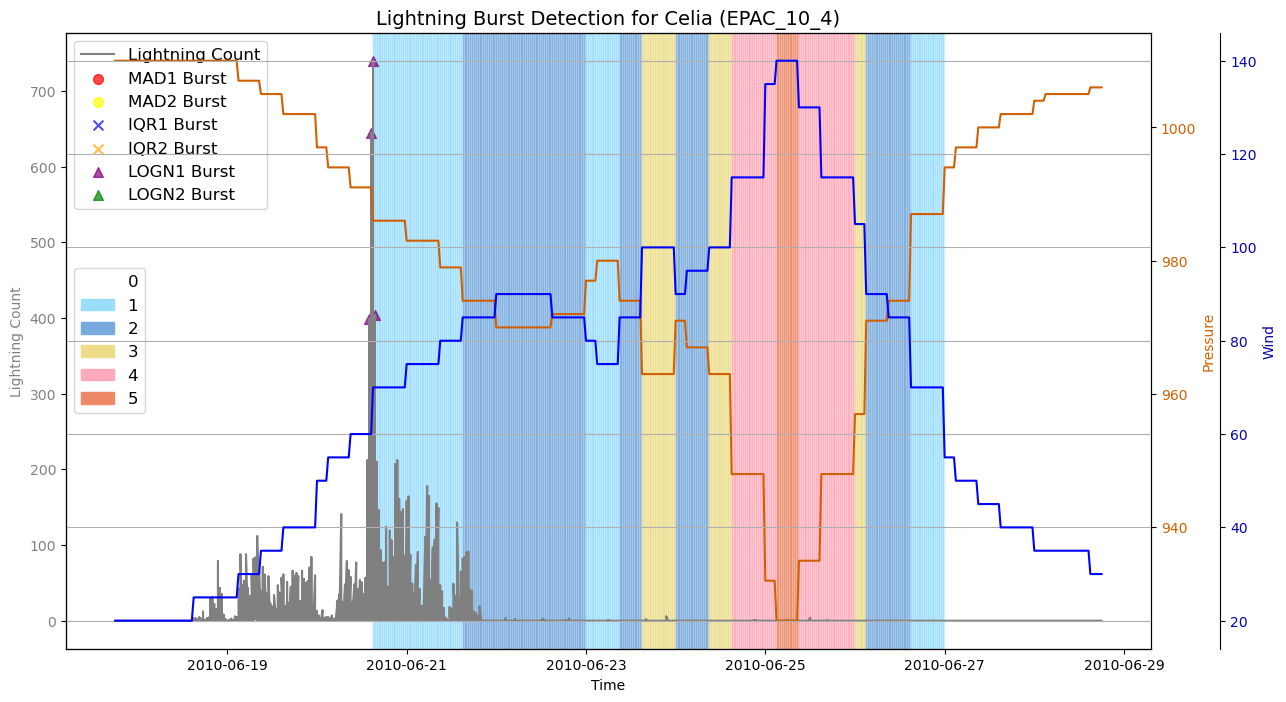

storm_code storm_name shear_quad  mad1_bursts  mad2_bursts  \
211  EPAC_10_4      Celia         DL            0            0   
212  EPAC_10_4      Celia         DR            0            0   
213  EPAC_10_4      Celia         UL            0            0   
214  EPAC_10_4      Celia         UR            0            0   

     mad1_threshold  mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  \
211        8.020353        9.241567            0            0        6.768781   
212        8.020353        9.241567            0            0        6.768781   
213        8.020353        9.241567            0            0        6.768781   
214        8.020353        9.241567            0            0        6.768781   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
211  ...             0          5.89286         7.389035          92   
212  ...             0          5.89286         7.389035          80   
213  ...             0          5.89286         7.389035          16   
214  ...             0          5.89286         7.389035          41   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
211        0.0        0.0        0.0        0.0         0.0         0.0  
212        0.0        0.0        0.0        0.0         5.0         0.0  
213        0.0        0.0        0.0        0.0         0.0         0.0  
214        0.0        0.0        0.0        0.0         0.0         0.0  

[4 rows x 22 columns]

In [15]:
# EPAC_10_4 - Celia
cyclone_id = 'EPAC_10_4'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

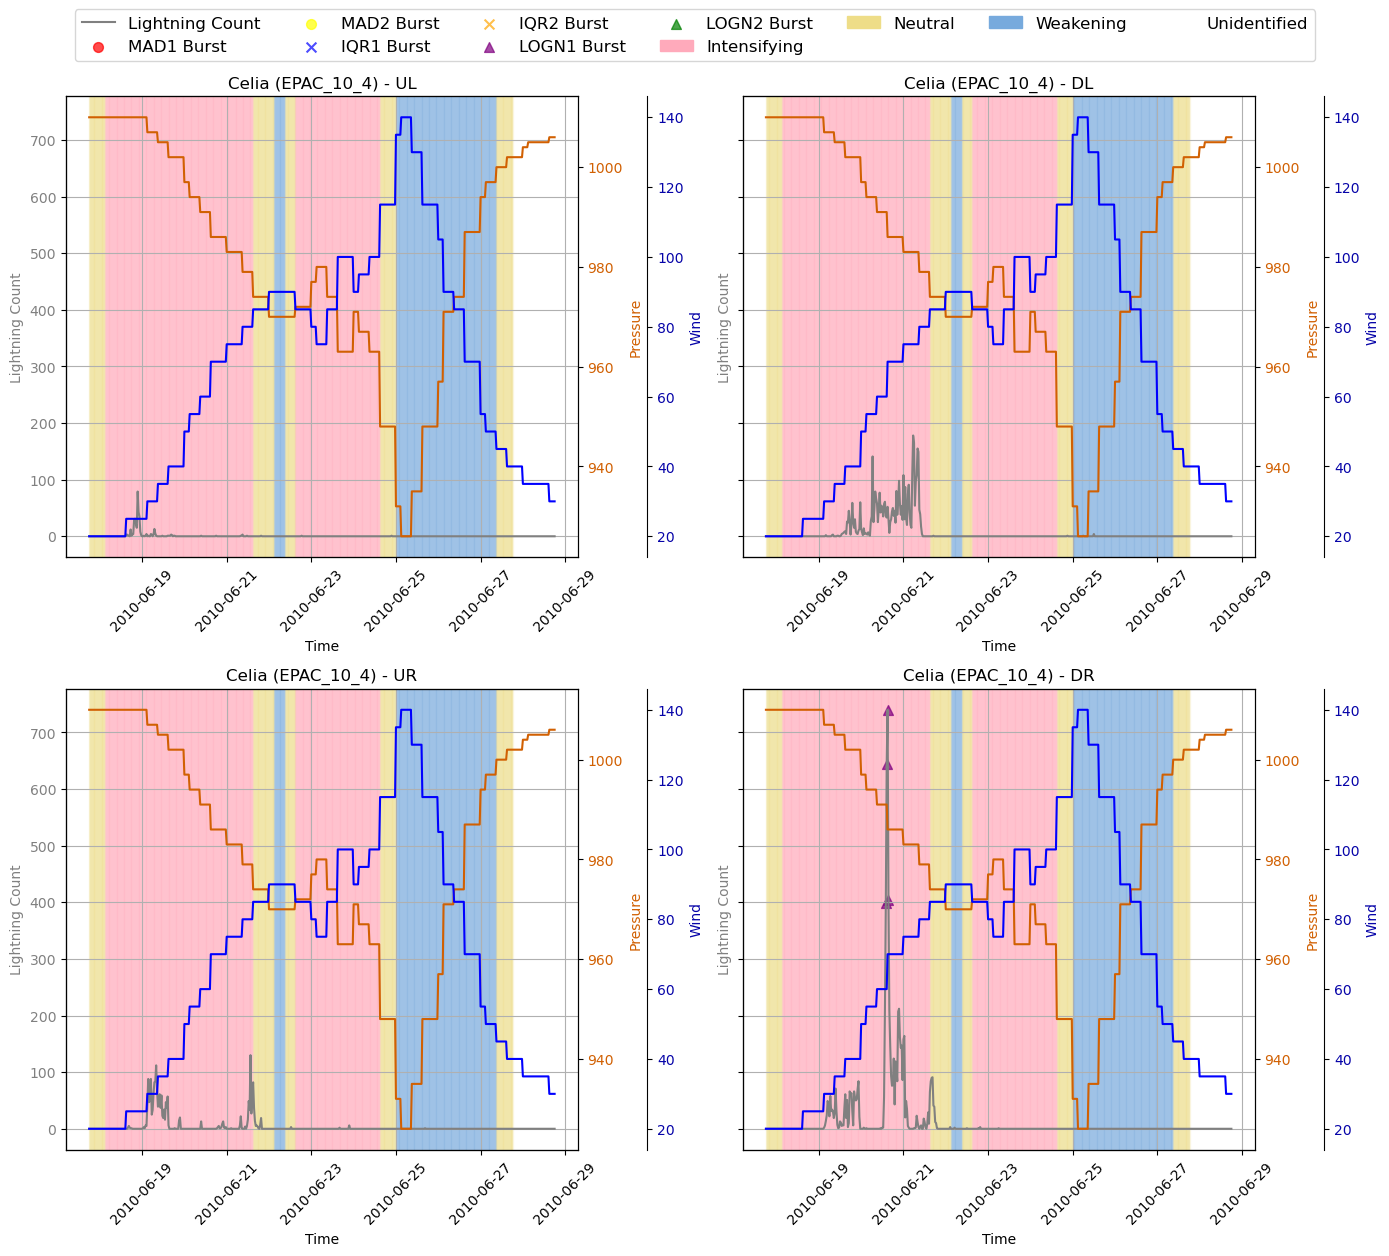

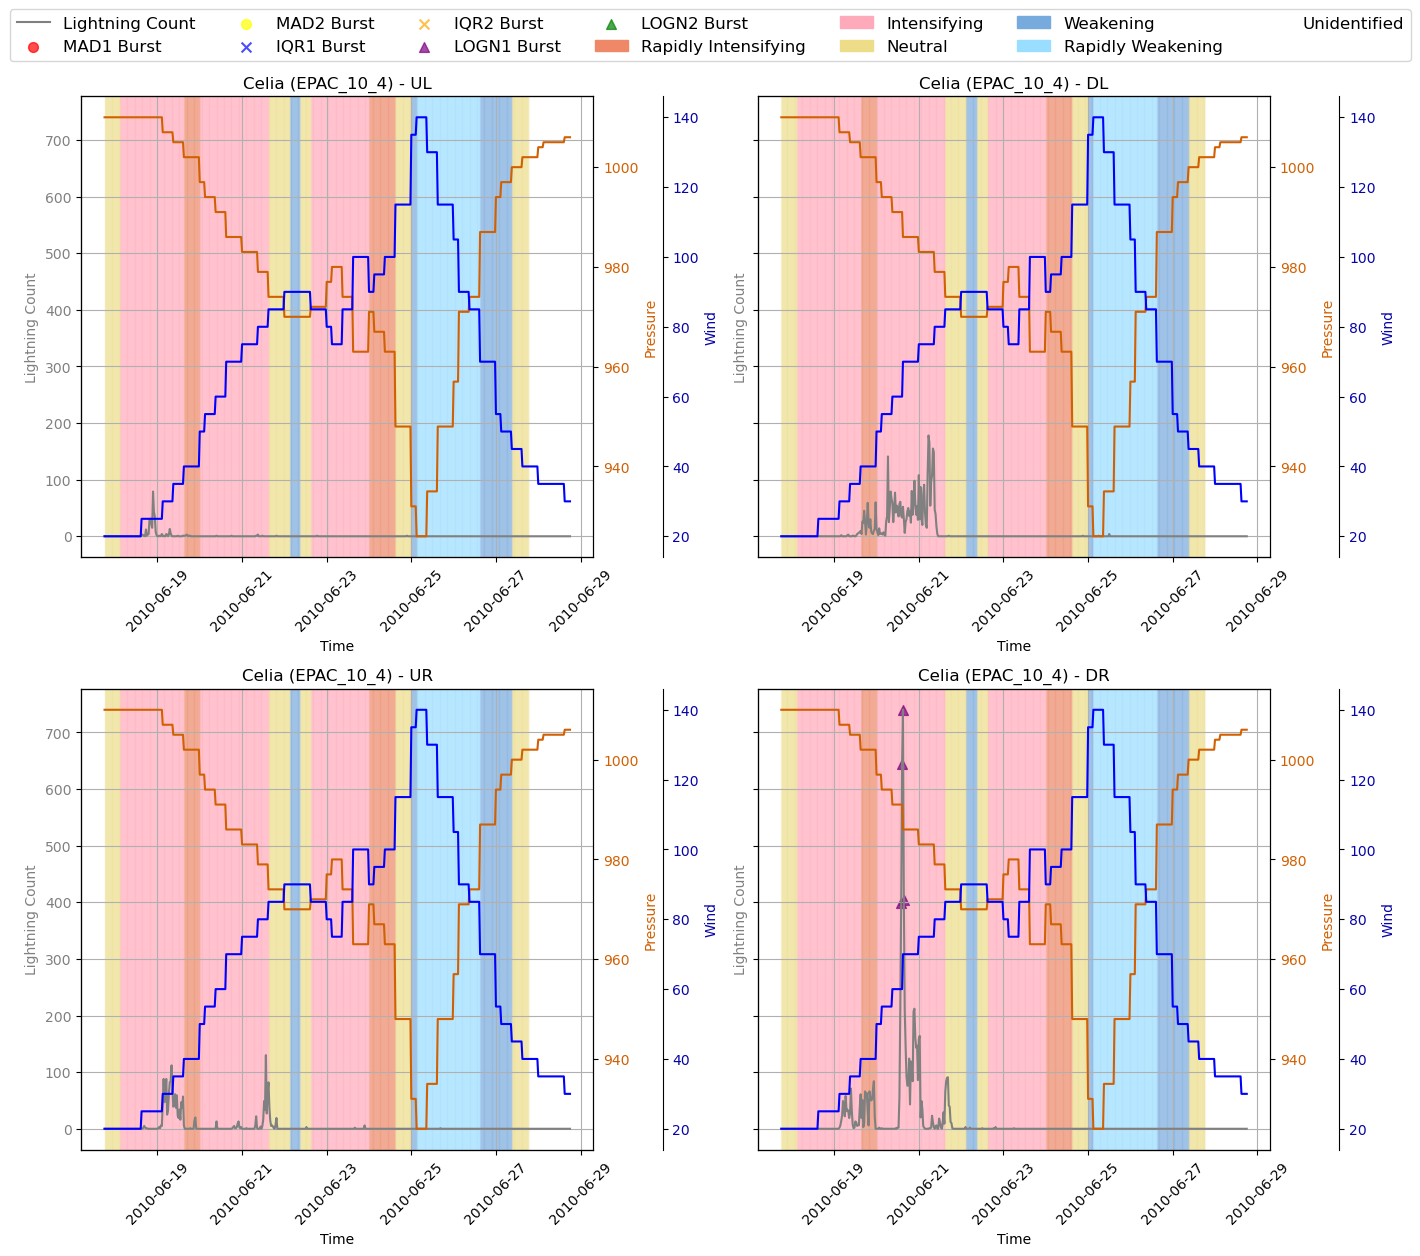

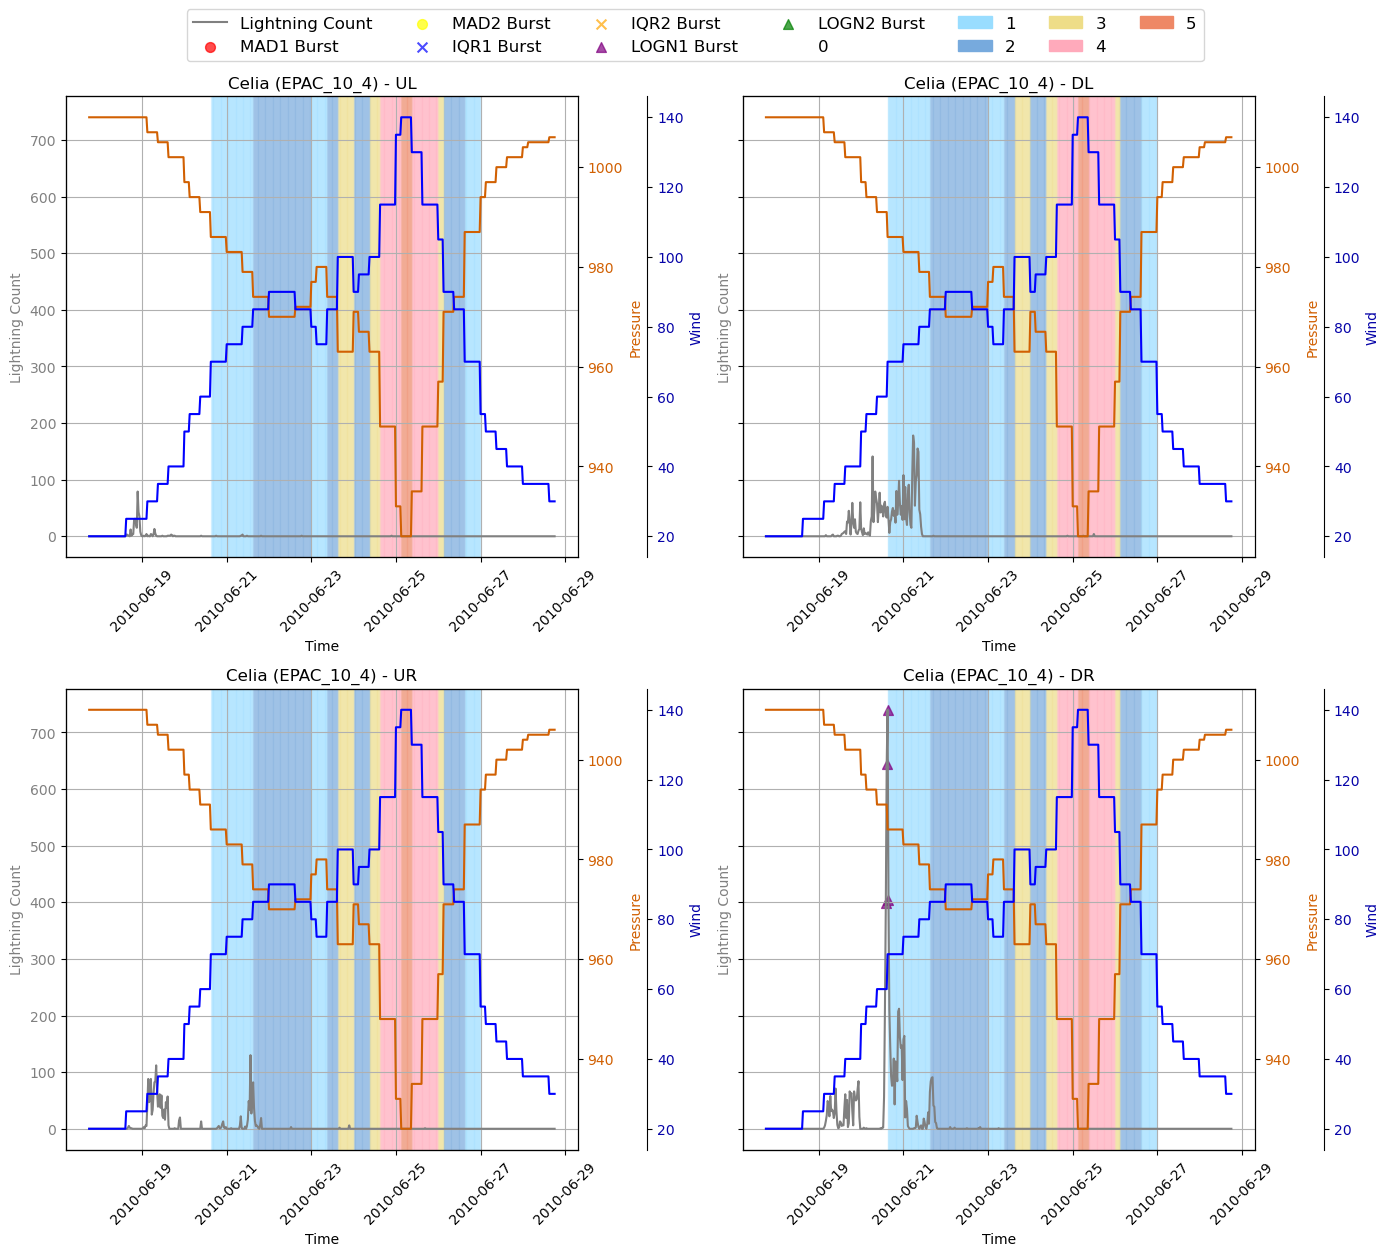

In [16]:
# EPAC_10_4 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

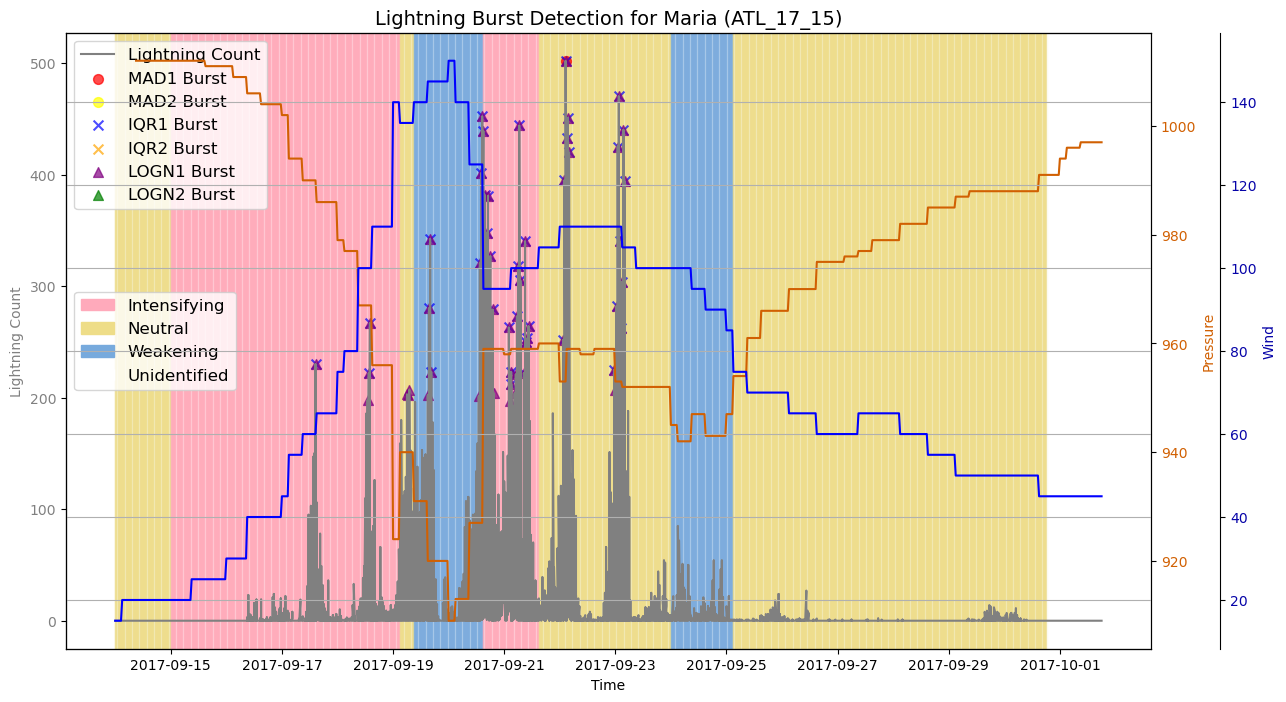

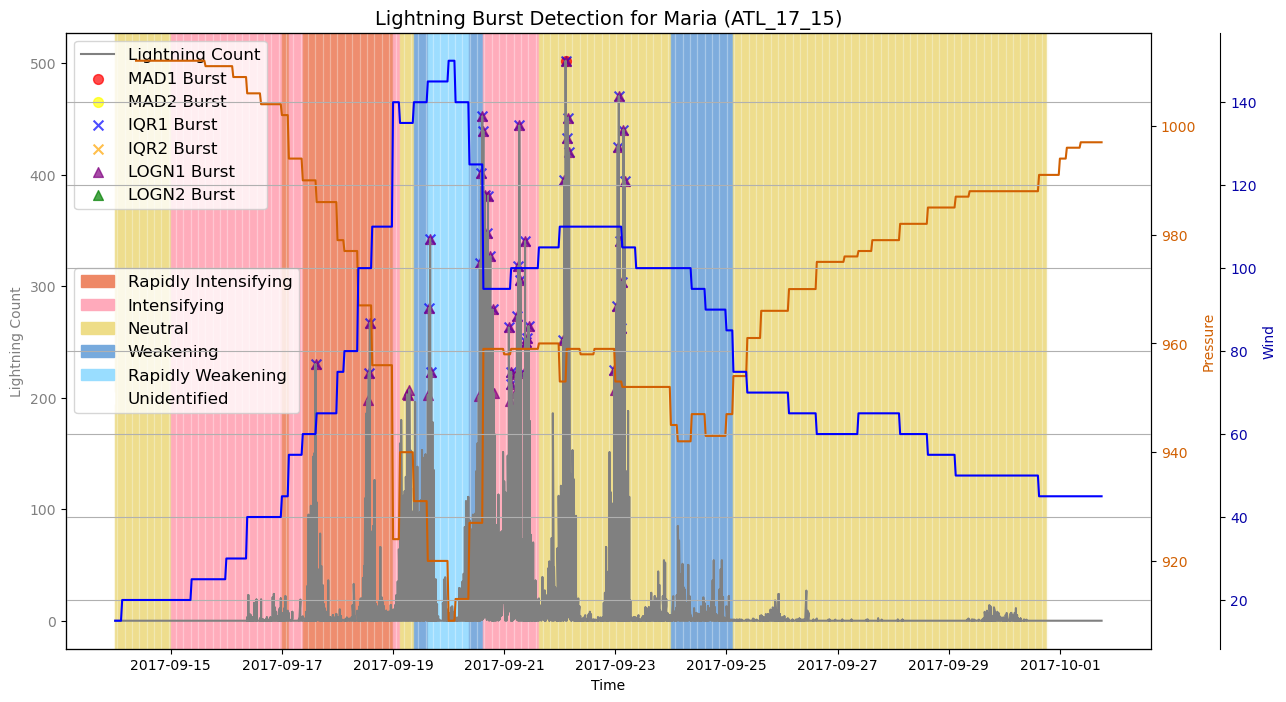

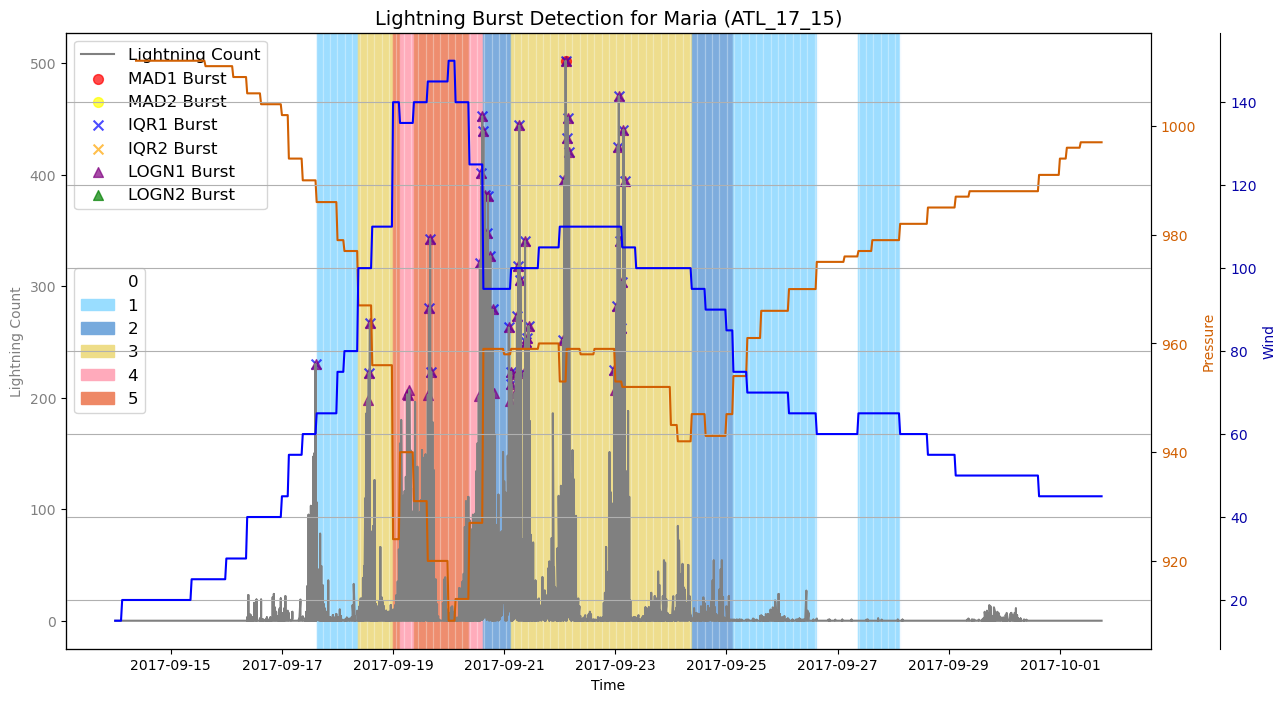

storm_code storm_name shear_quad  mad1_bursts  mad2_bursts  \
978  ATL_17_15      Maria         DL            0            0   
979  ATL_17_15      Maria         DR            0            0   
980  ATL_17_15      Maria         UL            0            0   
981  ATL_17_15      Maria         UR            1            0   

     mad1_threshold  mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  \
978        6.186209        7.284821            8            0        5.339139   
979        6.186209        7.284821           19            0        5.339139   
980        6.186209        7.284821            3            0        5.339139   
981        6.186209        7.284821           13            0        5.339139   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
978  ...             0         5.283362         6.780531         259   
979  ...             0         5.283362         6.780531         352   
980  ...             0         5.283362         6.780531         161   
981  ...             0         5.283362         6.780531         273   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
978       0.00        0.0       3.09        0.0        4.25         0.0  
979       0.00        0.0       5.40        0.0        5.97         0.0  
980       0.00        0.0       1.86        0.0        2.48         0.0  
981       0.37        0.0       4.76        0.0        6.59         0.0  

[4 rows x 22 columns]

In [17]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

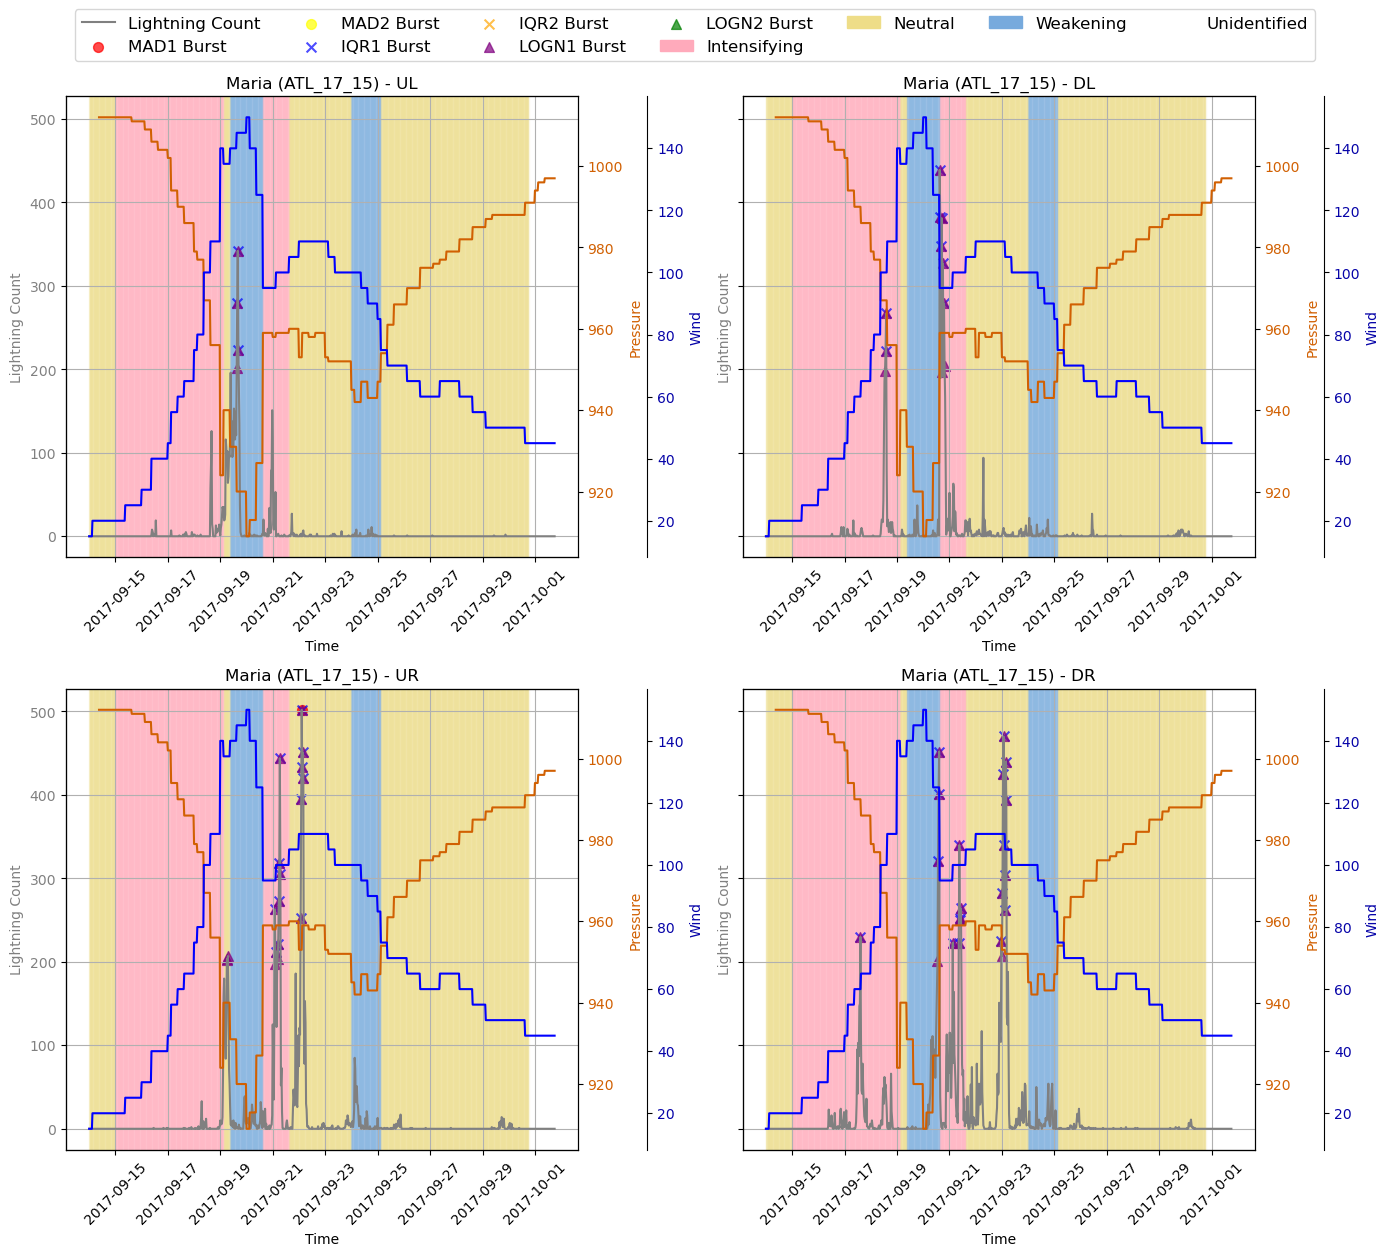

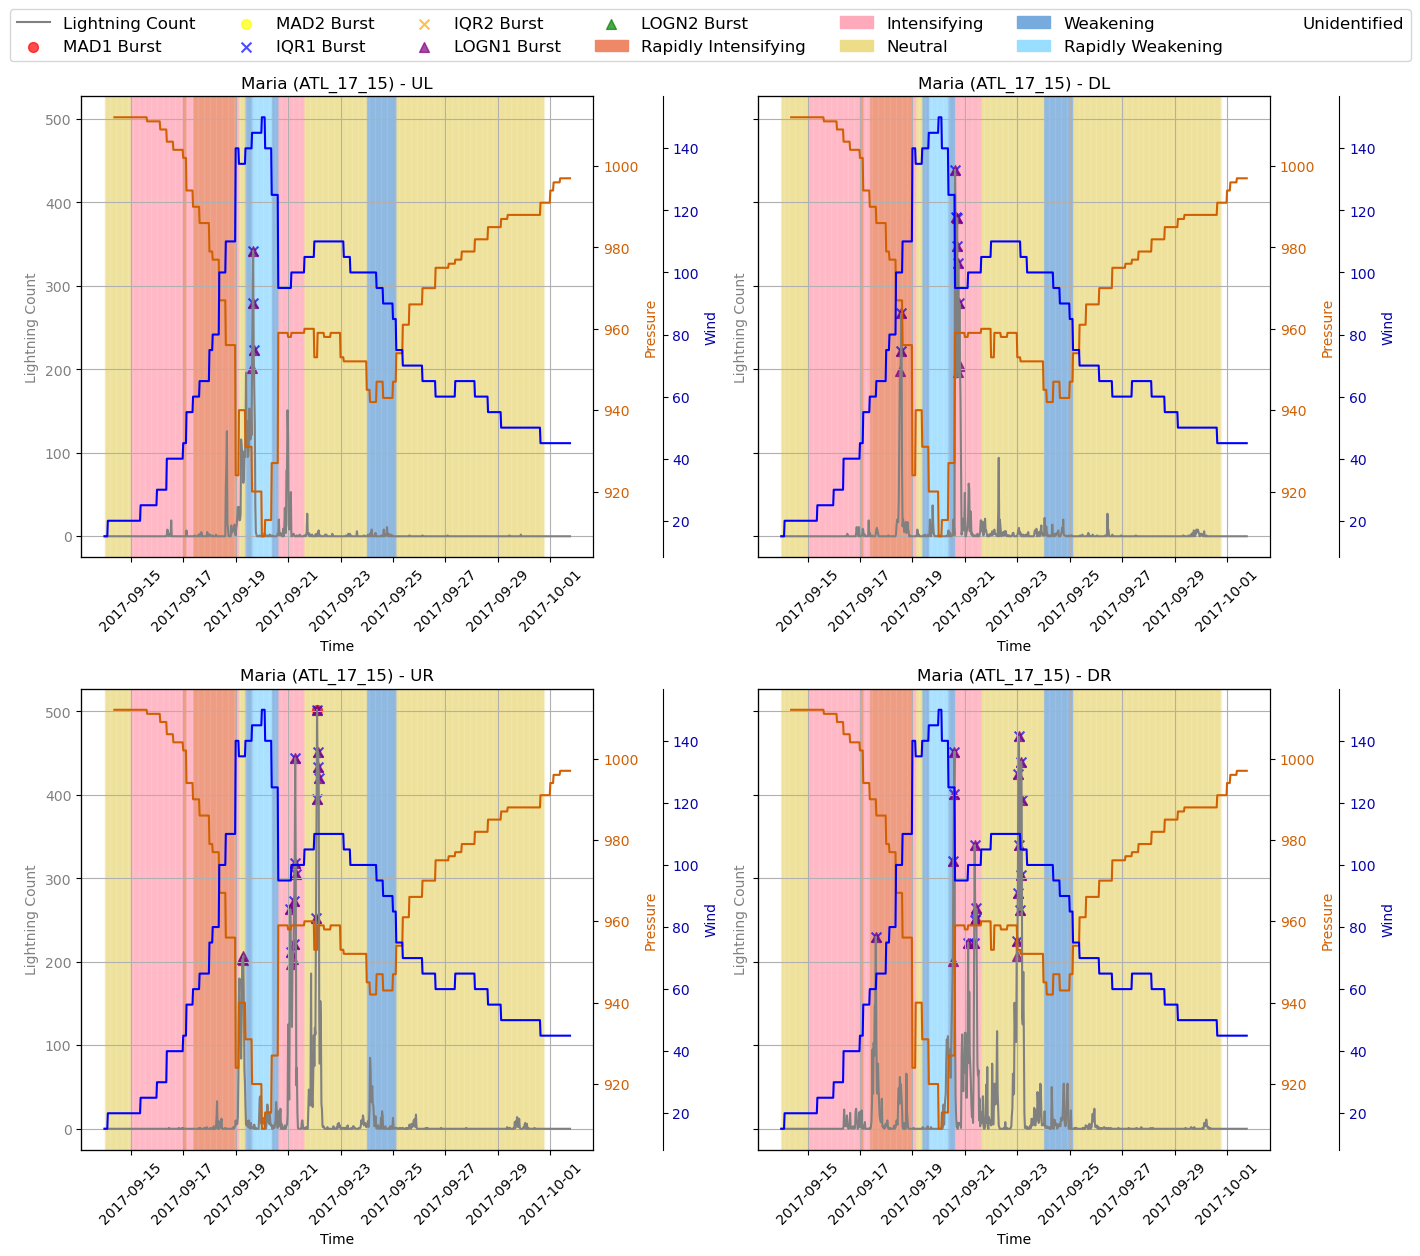

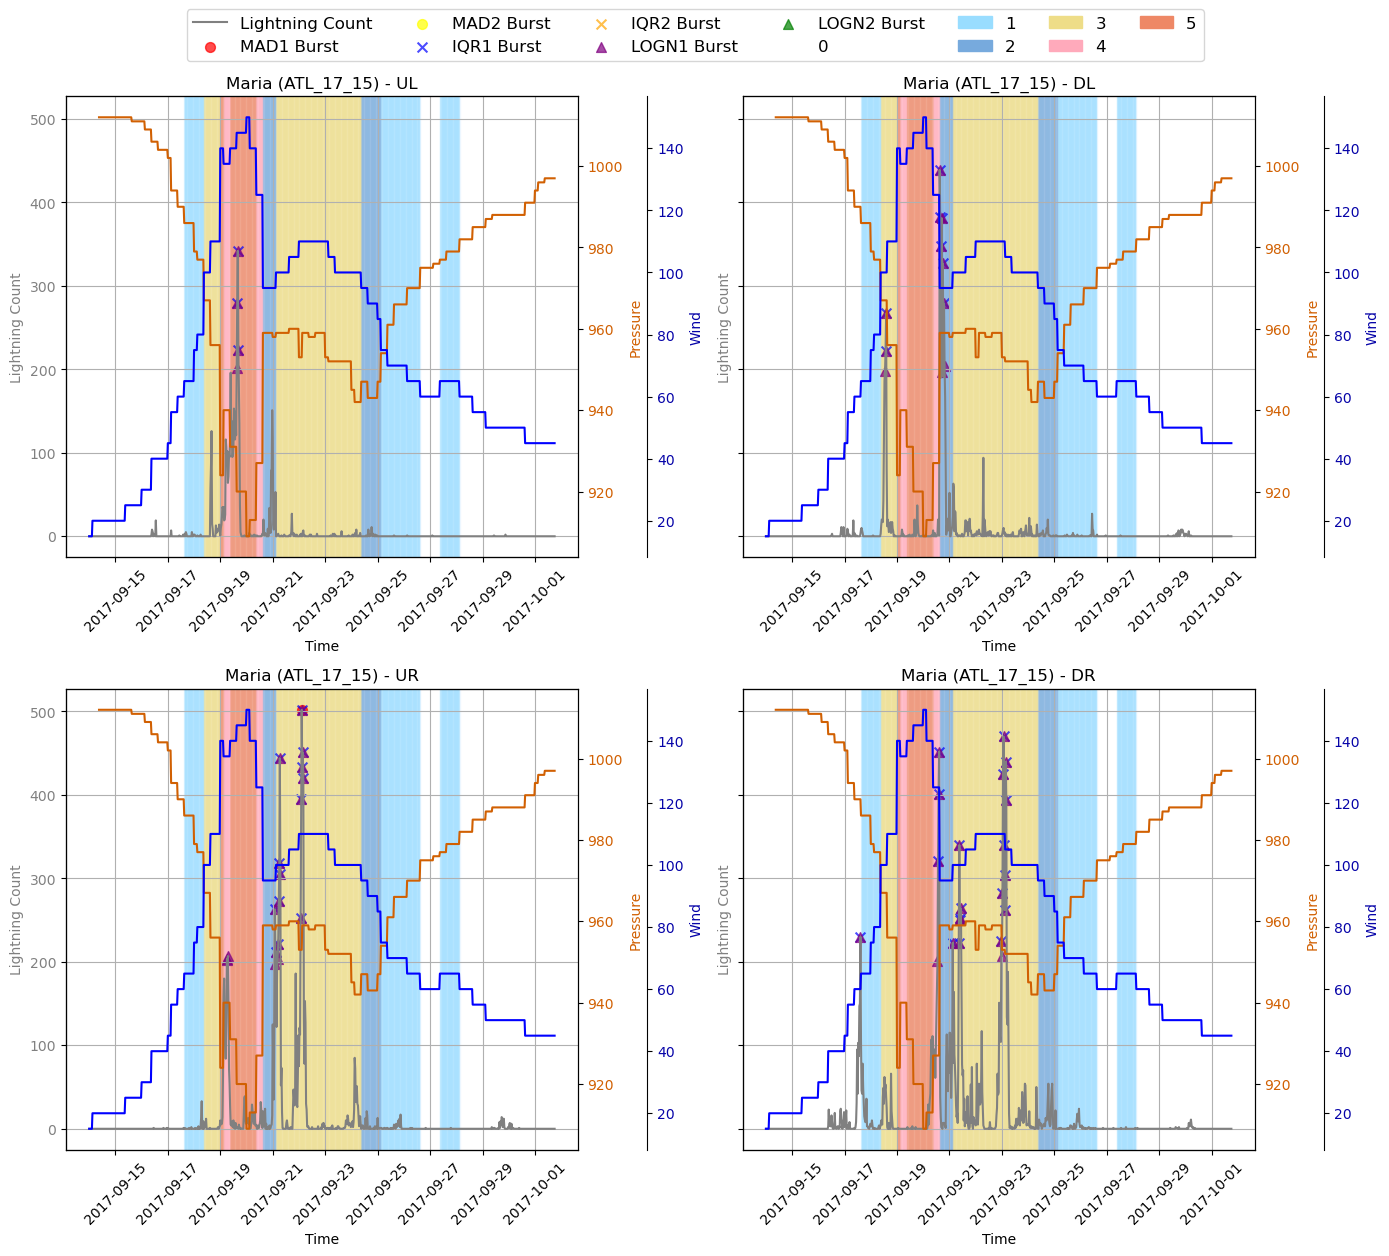

In [18]:
# ATL_17_15 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

In [19]:
# Export for external tool vis
rainband_data.write_csv("../analysis_data/rainband_lightning_data.csv")
tc_summary.to_csv("../analysis_data/rainband_threshold_summary.csv", index=False)
bursts.to_csv("../analysis_data/rainband_bursts.csv", index=False)

Next, we generate the visualizations for each TC as a .png file and save it to the `visualizations/` folder. We loop through each storm code in the rainband dataset and generate 2 overall rainband burst visualizations (one with intensification stages background colors, one with current category background colors) and 2 shear quadrant rainband burst visualizations.

In [ ]:
# Loop through each storm code and generate visualizations as png files for each
# Initialize storm codes, background coloring types, output directory
tc_list = rainband_data[["storm_code", "storm_name"]].unique()
bg_types = ["i3", "c5"] # Intensification 3 bins, Current Category 5 bins
output_dir = "visualizations/"
# Check if output directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Loop through each row in the TC list
for storm_code, storm_name in tc_list.iter_rows():
    # print(f"Exporting graphs for {storm_name} ({storm_code})")
    for bg_type in bg_types:
        # Call function to generate and save without displaying
        save_path = f"{output_dir}{storm_code}_{storm_name}_rainband_{bg_type}.png"
        plot_tc(storm_code, bursts, storm_names, rainband_data, bg_type, show=False, save_path=save_path)
        save_path = f"{output_dir}{storm_code}_{storm_name}_rainband_shear_{bg_type}.png" # Define different path for shear quad plots
        plot_tc_quadrants(storm_code, bursts, storm_names, rainband_data, bg_type, show=False, save_path=save_path)

In [20]:
cyclone_id = 'ATL_17_15'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3", show=False)

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','LOGN1'],
    'logn2':['logn2_threshold','LOGN2'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [ ]:
# No bursts detected
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

33 TCs of 1216 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
585 TCs of 1188 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.
